In [1]:
import pandas as pd
import numpy as np

In [2]:
#считываю данные
train = pd.read_csv('/Users/olgakalinina/Downloads/train-2.csv')

In [3]:
#создаю резервные данные
train2=train

In [4]:
#считаю кол-во заказов для каждого пользователя
number_of_orders=train2[['user_id', 'order_completed_at']] \
    .sort_values(['user_id', 'order_completed_at'], ascending=[True, False]) \
    .drop_duplicates() \
    .groupby('user_id', as_index=False).agg({'order_completed_at':'count'}) \
    .rename(columns={'order_completed_at': 'number_of_orders'})

In [5]:
#таблица с кол-вом заказа для каждого юзера
number_of_orders.describe()

,user_id,number_of_orders
count,20000.000000,20000.000000
mean,9999.500000,10.470300
std,5773.647028,11.905856
min,0.000000,3.000000
25%,4999.750000,4.000000
50%,9999.500000,6.000000
75%,14999.250000,12.000000
max,19999.000000,213.000000


In [6]:
#соединяю общую таблицу с таблицей по кол-ву заказов
train2=train2.merge(number_of_orders, on='user_id')

In [7]:
#Идея следующая: у нас есть БД с заказами: вычленим из нее 2 БД
#Первая: последние несколько заказов. Если в ней есть user_id_cart, то значит на тренировочных данных target = 1
#Почему беру несколько последних заказов, а не один? 
#Потому что клиент может каждый раз заказывать один и тот же хлеб, но стиральный порошок он будет заказывать, 
#например, раз в неделю
#Чтобы предложить ему этот порошок, необходимо анализировать не последнюю покупку, а несколько
#Вторая: все заказы пользователя (да, последние три заказа дублируются с первой БД, но 
#так как наша задача вычленить наиболее частые покупки и медиана общего кол-ва заказов = 6(не сильно больше 3),
# "общая усредненная" картина не меняется)

In [8]:
#нахожу последние три заказа каждого юзера
last_three_orders = train2[['user_id', 'order_completed_at']]
last_three_orders=last_three_orders.drop_duplicates()
last_three_orders=last_three_orders \
    .sort_values(['user_id', 'order_completed_at'], ascending=[True, False]) \
    .groupby('user_id').head(3)

In [9]:
#нахожу user_id_cart для каждого юзера для его последних 3 покупок
last_three_orders_with_cart=train2[train2.user_id.isin(last_three_orders.user_id)]
last_three_orders_with_cart=last_three_orders_with_cart[last_three_orders_with_cart.order_completed_at.isin(last_three_orders.order_completed_at)]
last_three_orders_with_cart['user_id_cart']=last_three_orders_with_cart['user_id'].astype(str)+';'+last_three_orders_with_cart['cart'].astype(str)

In [10]:
#присваиваю всем категориям таргет = 1
last_three_orders_with_cart_bougth=last_three_orders_with_cart['user_id_cart']
last_three_orders_with_cart_bougth=pd.DataFrame(data=last_three_orders_with_cart_bougth)
last_three_orders_with_cart_bougth['target']=1
last_three_orders_with_cart_bougth=last_three_orders_with_cart_bougth.drop_duplicates()

In [11]:
#что вообще покупал юзер, нахожу частоту покупок определенной категории
first_orders = train2
first_orders['user_id_cart'] = first_orders['user_id'].astype(str)+';'+first_orders['cart'].astype(str)
first_orders_number_of_purchases = first_orders.groupby('user_id_cart', as_index=False).agg({'cart':'count'}) \
    .rename(columns={'cart':'number_of_purchases'})
first_orders=first_orders.merge(first_orders_number_of_purchases, on = 'user_id_cart')
first_orders['share_of_total_purchases']=(first_orders.number_of_purchases/first_orders.number_of_orders).round(3)

In [12]:
#создаю основной датасет с общими покупками пользователя, с частотой покупки каждой категории, 
#с тем была ли эта категория куплена в последние 3 покупки
final_data=first_orders.merge(last_three_orders_with_cart_bougth, on='user_id_cart', how = 'left')
final_data=final_data[['user_id', 'cart', 'user_id_cart', 'share_of_total_purchases', 'target']].drop_duplicates()

In [13]:
#смотрю пропуски в target, означает, что в последних трех покупках наш юзер не покупал эту категорию
final_data.isnull().sum()

user_id                          0
cart                             0
user_id_cart                     0
share_of_total_purchases         0
target                      498936
dtype: int64

In [14]:
#заполняю таргет 0
final_data=final_data.fillna(0)

In [15]:
final_data

,user_id,cart,user_id_cart,share_of_total_purchases,target
0,2,399,2;399,0.067,0.0
1,2,14,2;14,0.067,0.0
2,2,198,2;198,0.133,0.0
4,2,88,2;88,0.133,0.0
6,2,157,2;157,0.133,0.0
...,...,...,...,...,...
3123057,16887,329,16887;329,0.667,1.0
3123059,16887,0,16887;0,0.333,1.0
3123060,16887,333,16887;333,0.667,1.0
3123062,16887,325,16887;325,0.333,1.0


In [16]:
#перевожу значение таргета в int
final_data.target=final_data.target.astype(int)

In [17]:
#готовлю данные для случайного леса
X = final_data[['user_id', 'cart', 'share_of_total_purchases']]
X=X.round(3).to_numpy()
y = final_data[['target']]
y=np.ravel(y)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [19]:
#подбираю параметры для случайного леса
#clf_rf=RandomForestClassifier()
#parameters={'n_estimators':[65, 75, 85],
    #'max_depth':[3, 4, 7, 8, 9, 10], 'min_samples_split':[800, 1000, 3000, 5000],
           #'min_samples_leaf':[325, 350, 400, 1000, 3000]}
#grid_search = RandomizedSearchCV(clf_rf, parameters, cv=5)
#grid_search.fit(X, y) на подбор параметров ушло примерно 20 минут
#grid_search.best_params_
#{'n_estimators': 65,
# 'min_samples_split': 1000,
# 'min_samples_leaf': 3000,
# 'max_depth': 8}

In [20]:
#чтобы уменьшить переобучаемость дерева, уменьшу max_depth до 3
clf_rf=RandomForestClassifier(n_estimators= 75,
 min_samples_split = 1000,
 min_samples_leaf= 3000,
 max_depth= 3)

In [21]:
clf_rf.fit(X, y)

RandomForestClassifier(max_depth=3, min_samples_leaf=3000,
                       min_samples_split=1000, n_estimators=75)

In [22]:
#загружаю тестовую выборку
sub= pd.read_csv('/Users/olgakalinina/Downloads/sample_submission.csv')

In [23]:
sub=sub.rename(columns={'id':'user_id_cart'})

In [24]:
#чтобы найти частоту покупки категории юзером присоединяю final_data
sub=sub.merge(final_data, on ='user_id_cart', how='left')

In [25]:
#выделяю тестовую выборку
X_test=sub[['user_id', 'cart', 'share_of_total_purchases']]
y_test=sub[['target_x']].to_numpy()

In [26]:
from sklearn.metrics import f1_score

In [27]:
#предсказываю
y_pred=clf_rf.predict_proba(X_test)

<AxesSubplot:>

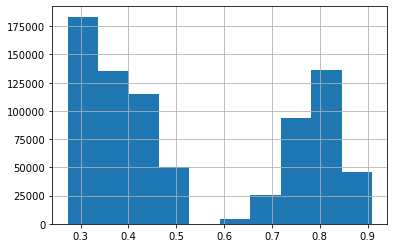

In [28]:
#смотрю на распределение вероятностей
pd.Series(y_pred[:,1]).hist()

In [29]:
#если вероятность больше 0,7 то покупатель купит эту категорию товаров
y_pred = np.where(y_pred[:, 1]>0.7, 1, 0)

In [30]:
#находим f1 score
f1_score(y_test, y_pred, average='micro')

0.5001967236342889

In [31]:
sub2=pd.read_csv('/Users/olgakalinina/Downloads/sample_submission.csv')

In [32]:
submissions=pd.DataFrame()

In [33]:
submissions['id']=sub2['id']

In [34]:
submissions['target']=y_pred

In [35]:
submissions.to_csv('submissions.csv', index=False)